In [1]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


In [3]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


In [4]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,SST,line_type,var_name):

    # plot
    plot_date(time,SST,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

In [5]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

In [6]:
from google.colab import auth
auth.authenticate_user()

In [7]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, time, ssh, sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>258 AND lon<280 AND lat>18 AND lat<30
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [102]:
output

,lon,lat,time,ssh,sst
0,268.625,20.375,729390.0,0.3235,24.00
1,279.375,23.875,729390.0,0.5691,24.00
2,268.625,22.875,729390.0,0.1911,22.50
3,278.875,18.375,729390.0,0.8239,27.75
4,273.375,22.875,729390.0,0.4535,25.20
...,...,...,...,...,...
13345215,276.625,20.375,735963.0,0.7722,27.90
13345216,275.875,27.875,735963.0,0.3489,25.35
13345217,277.375,24.125,735963.0,0.2642,26.85
13345218,266.375,19.125,735963.0,0.3486,25.80


In [103]:
ouput_gb_lon_lat = output.groupby(['lon','lat']).mean()

In [104]:
test = ouput_gb_lon_lat.reset_index()

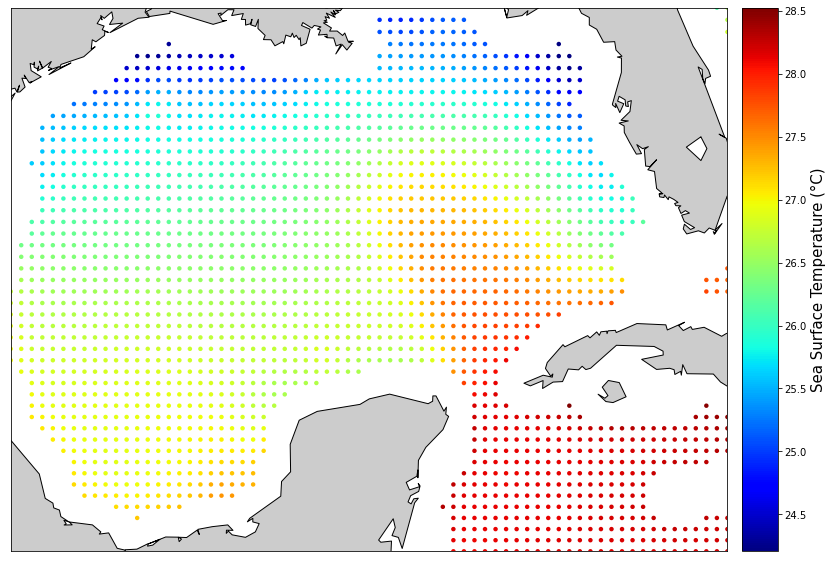

In [105]:
plot_im(test['lon'], test['lat'], test['sst'], 20, 'Sea Surface Temperature (°C)')

In [106]:
def plot_derivative_ts(df):
  length = len(df)
  derivative_sst = zeros((length))
  derivative_sst[1:] = df['sst'].to_numpy()[1:] - df['sst'].to_numpy()[:length-1]
  plot_ts(df['time'], derivative_sst, '-*', 'Difference of temperature with the preceding day (°C)')

In [107]:
sst_ts_df = output.groupby(['time']).mean().reset_index()

sst_ts_df

,time,lon,lat,ssh,sst
0,729390.0,270.671675,24.038424,0.341775,23.433030
1,729391.0,270.671675,24.038424,0.341648,23.376872
2,729392.0,270.671675,24.038424,0.341425,23.321379
3,729393.0,270.671675,24.038424,0.341445,23.336158
4,729394.0,270.671675,24.038424,0.341054,23.489778
...,...,...,...,...,...
6569,735959.0,270.671675,24.038424,0.485143,25.754631
6570,735960.0,270.671675,24.038424,0.484065,25.648227
6571,735961.0,270.671675,24.038424,0.482946,25.767635
6572,735962.0,270.671675,24.038424,0.481523,25.960197


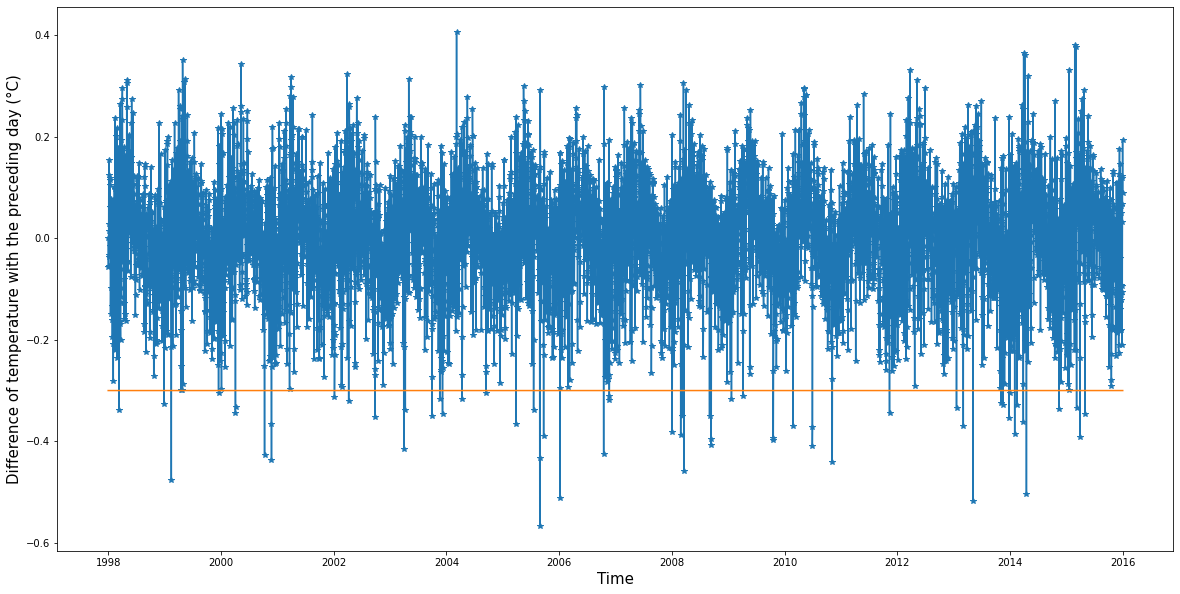

In [108]:
plot_derivative_ts(sst_ts_df)
plot_ts(sst_ts_df['time'],np.array([-0.3 for i in range(6574)]), '-', 'Difference of temperature with the preceding day (°C)')

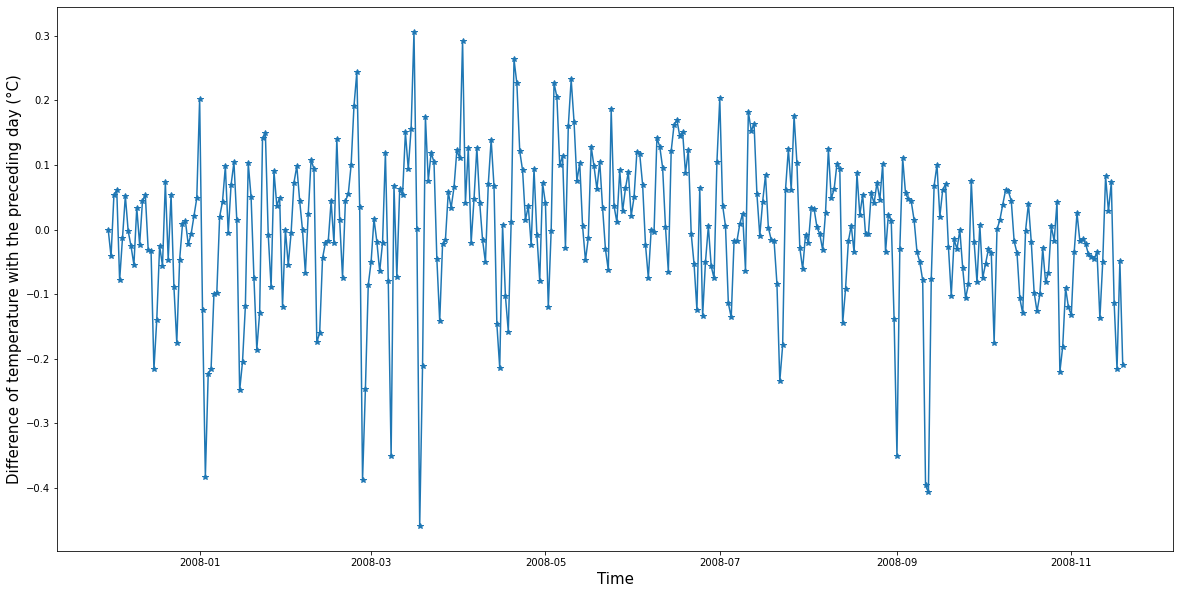

In [109]:
plot_derivative_ts(sst_ts_df.iloc[3620:3976])

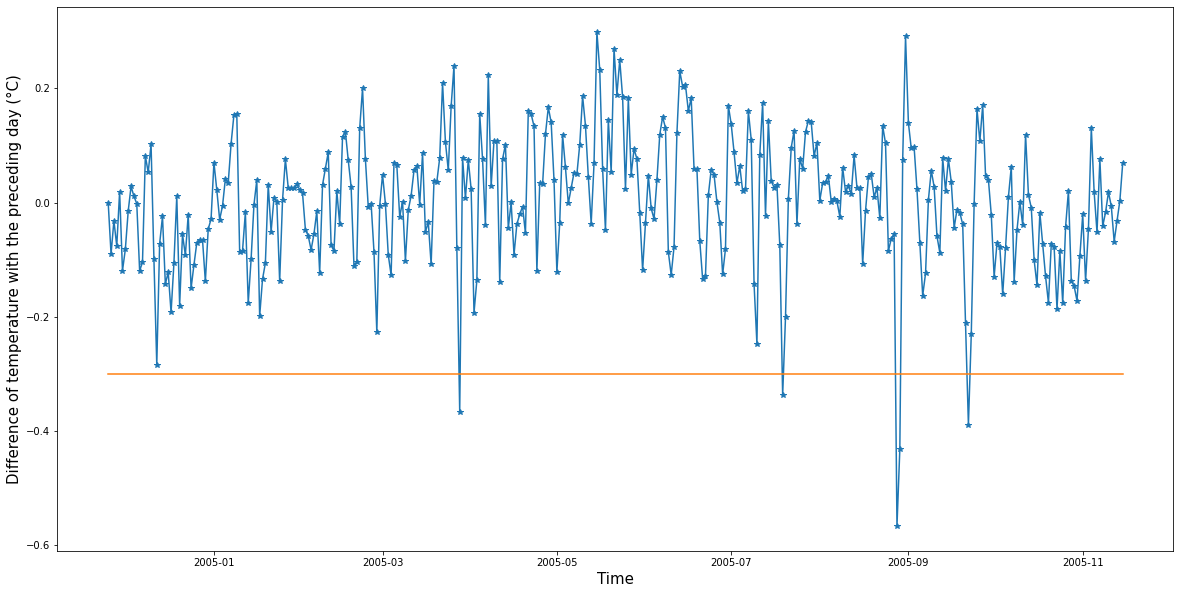

In [110]:
plot_derivative_ts(sst_ts_df.iloc[2520:2876])
plot_ts(sst_ts_df.iloc[2520:2876]['time'],np.array([-0.3 for i in range(2876-2520)]), '-', 'Difference of temperature with the preceding day (°C)')

In [111]:
  length = len(sst_ts_df)
  derivative_sst = zeros((length))
  derivative_sst[1:] = sst_ts_df['sst'].to_numpy()[1:] - sst_ts_df['sst'].to_numpy()[:length-1]

In [112]:
sst_ts_df['diff_sst'] = derivative_sst
sst_ts_df

,time,lon,lat,ssh,sst,diff_sst
0,729390.0,270.671675,24.038424,0.341775,23.433030,0.000000
1,729391.0,270.671675,24.038424,0.341648,23.376872,-0.056158
2,729392.0,270.671675,24.038424,0.341425,23.321379,-0.055493
3,729393.0,270.671675,24.038424,0.341445,23.336158,0.014778
4,729394.0,270.671675,24.038424,0.341054,23.489778,0.153621
...,...,...,...,...,...,...
6569,735959.0,270.671675,24.038424,0.485143,25.754631,-0.210369
6570,735960.0,270.671675,24.038424,0.484065,25.648227,-0.106404
6571,735961.0,270.671675,24.038424,0.482946,25.767635,0.119409
6572,735962.0,270.671675,24.038424,0.481523,25.960197,0.192562


In [113]:
sst_ts_df.loc[sst_ts_df['diff_sst'] < -0.3].count()['diff_sst']

59

In [114]:
derivative_sst

array([ 0.        , -0.05615764, -0.05549261, ...,  0.11940887,
        0.19256158,  0.08985222])

In [115]:
from sklearn import linear_model

omega = 1/365.25

X = zeros((6574,3))
y = sst_ts_df['diff_sst'].to_numpy()

time = sst_ts_df['time'].to_numpy()

X[:,0] = time
X[:,1] = sin(2 * pi * omega * time)
X[:,2] = cos(2 * pi * omega * time)

model = linear_model.LinearRegression()

model.fit(X,y)

y_pred = model.predict(X)



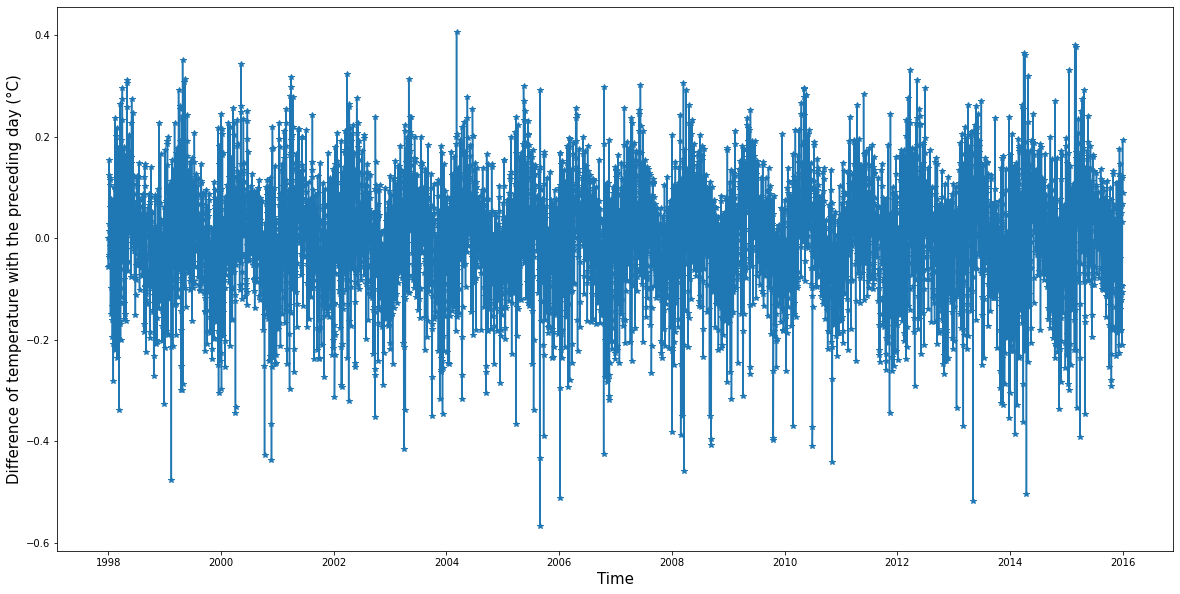

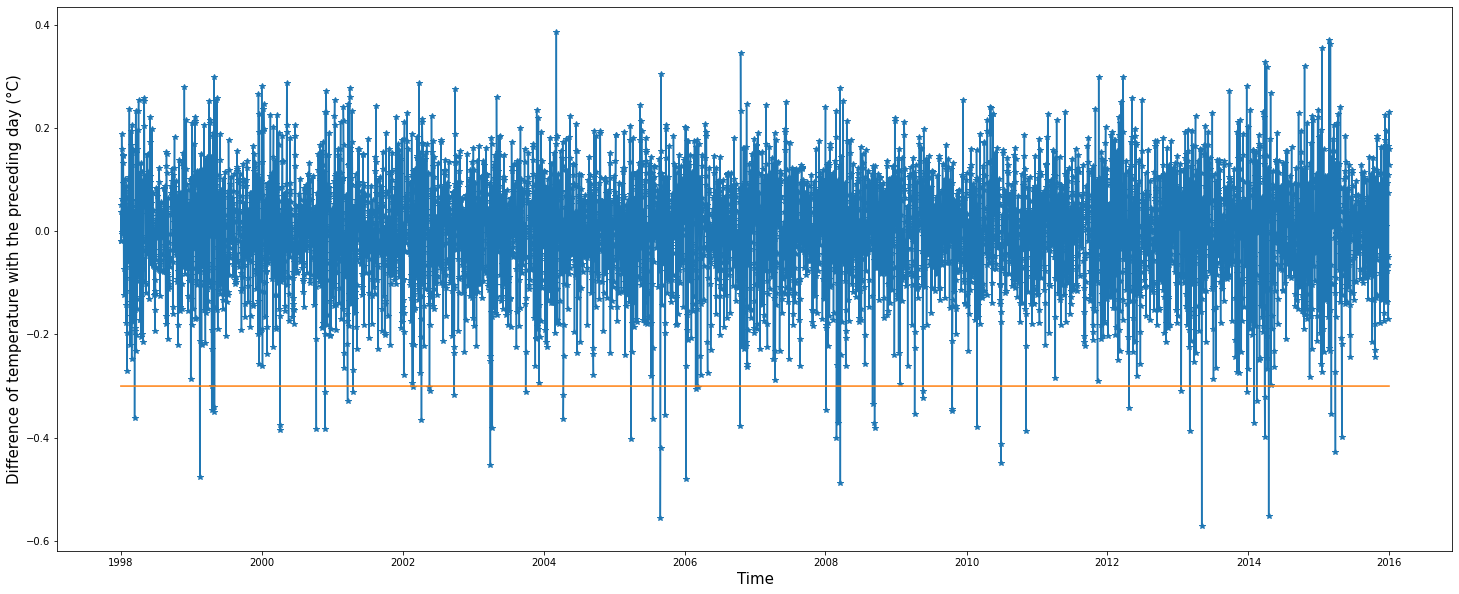

In [116]:
plot_derivative_ts(sst_ts_df)
figure(figsize=(25,10))
plot_ts(time, derivative_sst-y_pred, '-*', 'Prediction of temperature')
plot_ts(sst_ts_df['time'],np.array([-0.3 for i in range(6574)]), '-', 'Difference of temperature with the preceding day (°C)')

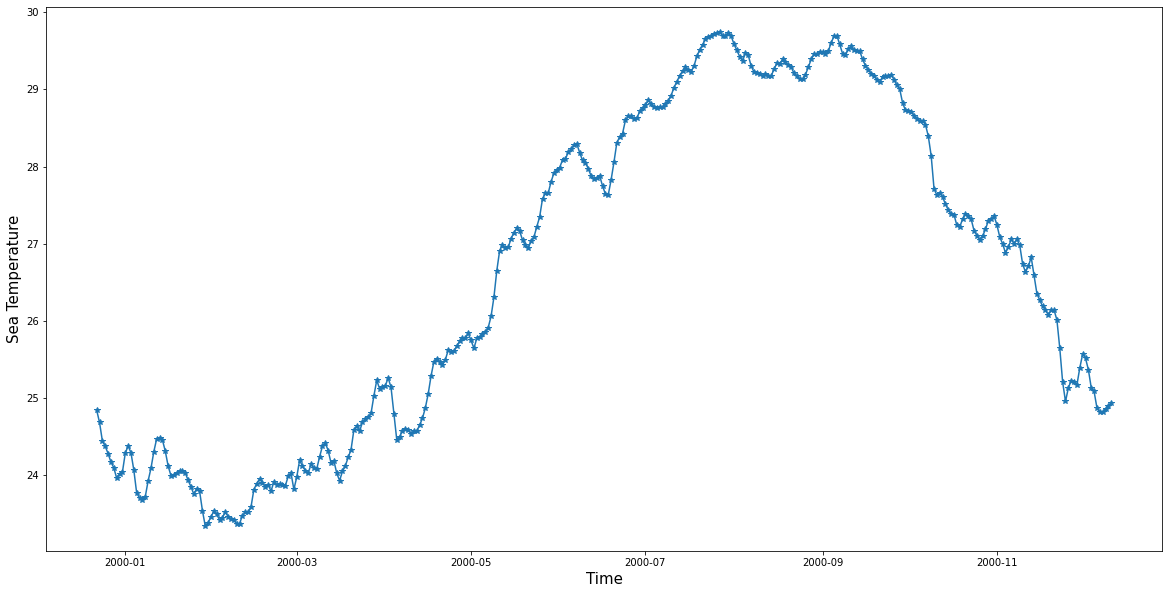

In [117]:
plot_ts(sst_ts_df.iloc[720:1076]['time'], sst_ts_df.iloc[720:1076]['sst'], '-*', 'Sea Temperature')

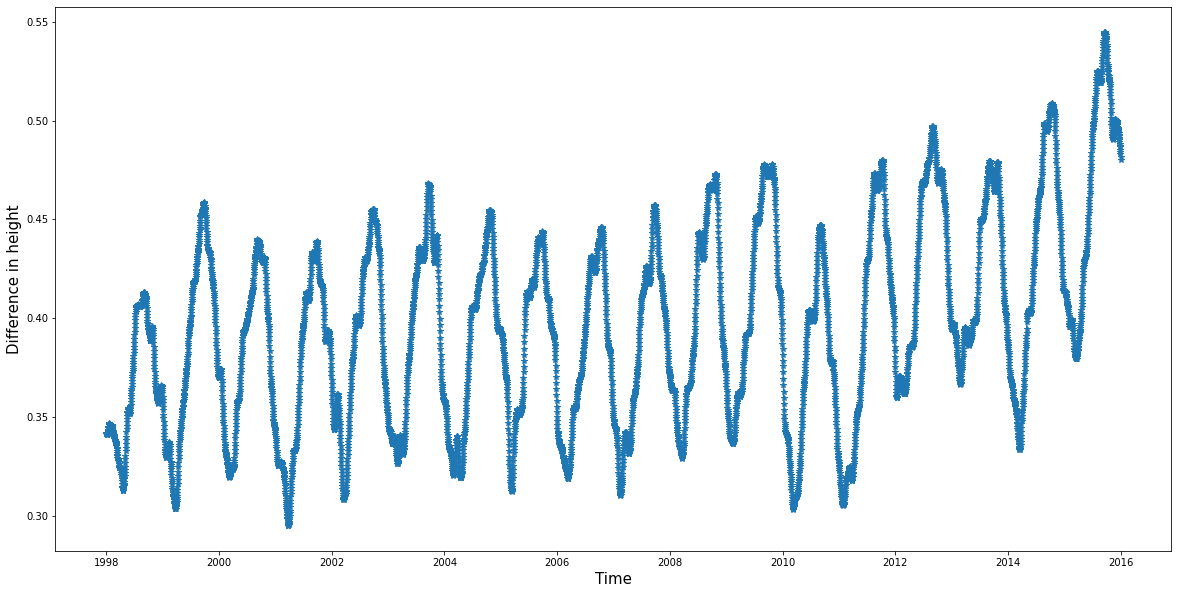

In [118]:
plot_ts(sst_ts_df['time'], sst_ts_df['ssh'], '-*', 'Difference in height')

In [119]:
sst_ts_df['diff_sst'] = derivative_sst-y_pred
sst_ts_df

,time,lon,lat,ssh,sst,diff_sst
0,729390.0,270.671675,24.038424,0.341775,23.433030,0.037795
1,729391.0,270.671675,24.038424,0.341648,23.376872,-0.019053
2,729392.0,270.671675,24.038424,0.341425,23.321379,-0.019088
3,729393.0,270.671675,24.038424,0.341445,23.336158,0.050471
4,729394.0,270.671675,24.038424,0.341054,23.489778,0.188591
...,...,...,...,...,...,...
6569,735959.0,270.671675,24.038424,0.485143,25.754631,-0.169548
6570,735960.0,270.671675,24.038424,0.484065,25.648227,-0.066208
6571,735961.0,270.671675,24.038424,0.482946,25.767635,0.158967
6572,735962.0,270.671675,24.038424,0.481523,25.960197,0.231470


In [120]:
count_typhoon_array = zeros(len(sst_ts_df))
for i in range(1,len(sst_ts_df)):
  if sst_ts_df.iloc[i]['diff_sst'] <= -0.4:
    count_typhoon_array[i] = count_typhoon_array[i-1] + 1
  else:
    count_typhoon_array[i] = count_typhoon_array[i-1]

sst_ts_df['typhoon_count'] = count_typhoon_array

sst_ts_df

,time,lon,lat,ssh,sst,diff_sst,typhoon_count
0,729390.0,270.671675,24.038424,0.341775,23.433030,0.037795,0.0
1,729391.0,270.671675,24.038424,0.341648,23.376872,-0.019053,0.0
2,729392.0,270.671675,24.038424,0.341425,23.321379,-0.019088,0.0
3,729393.0,270.671675,24.038424,0.341445,23.336158,0.050471,0.0
4,729394.0,270.671675,24.038424,0.341054,23.489778,0.188591,0.0
...,...,...,...,...,...,...,...
6569,735959.0,270.671675,24.038424,0.485143,25.754631,-0.169548,12.0
6570,735960.0,270.671675,24.038424,0.484065,25.648227,-0.066208,12.0
6571,735961.0,270.671675,24.038424,0.482946,25.767635,0.158967,12.0
6572,735962.0,270.671675,24.038424,0.481523,25.960197,0.231470,12.0


In [121]:
import matplotlib.dates as mdates
from datetime import datetime

year_in_df = zeros(len(sst_ts_df))
for i in range(len(sst_ts_df)):
  matplotlib_date = sst_ts_df.iloc[i]['time']
  date = mdates.num2date(matplotlib_date)
  year_in_df[i] = date.year

sst_ts_df['year'] = year_in_df

sst_ts_df

,time,lon,lat,ssh,sst,diff_sst,typhoon_count,year
0,729390.0,270.671675,24.038424,0.341775,23.433030,0.037795,0.0,1998.0
1,729391.0,270.671675,24.038424,0.341648,23.376872,-0.019053,0.0,1998.0
2,729392.0,270.671675,24.038424,0.341425,23.321379,-0.019088,0.0,1998.0
3,729393.0,270.671675,24.038424,0.341445,23.336158,0.050471,0.0,1998.0
4,729394.0,270.671675,24.038424,0.341054,23.489778,0.188591,0.0,1998.0
...,...,...,...,...,...,...,...,...
6569,735959.0,270.671675,24.038424,0.485143,25.754631,-0.169548,12.0,2015.0
6570,735960.0,270.671675,24.038424,0.484065,25.648227,-0.066208,12.0,2015.0
6571,735961.0,270.671675,24.038424,0.482946,25.767635,0.158967,12.0,2015.0
6572,735962.0,270.671675,24.038424,0.481523,25.960197,0.231470,12.0,2015.0


In [122]:
month_in_df = zeros(len(sst_ts_df))
for i in range(len(sst_ts_df)):
  matplotlib_date = sst_ts_df.iloc[i]['time']
  date = mdates.num2date(matplotlib_date)
  month_in_df[i] = date.month

sst_ts_df['month'] = month_in_df

sst_ts_df

,time,lon,lat,ssh,sst,diff_sst,typhoon_count,year,month
0,729390.0,270.671675,24.038424,0.341775,23.433030,0.037795,0.0,1998.0,1.0
1,729391.0,270.671675,24.038424,0.341648,23.376872,-0.019053,0.0,1998.0,1.0
2,729392.0,270.671675,24.038424,0.341425,23.321379,-0.019088,0.0,1998.0,1.0
3,729393.0,270.671675,24.038424,0.341445,23.336158,0.050471,0.0,1998.0,1.0
4,729394.0,270.671675,24.038424,0.341054,23.489778,0.188591,0.0,1998.0,1.0
...,...,...,...,...,...,...,...,...,...
6569,735959.0,270.671675,24.038424,0.485143,25.754631,-0.169548,12.0,2015.0,12.0
6570,735960.0,270.671675,24.038424,0.484065,25.648227,-0.066208,12.0,2015.0,12.0
6571,735961.0,270.671675,24.038424,0.482946,25.767635,0.158967,12.0,2015.0,12.0
6572,735962.0,270.671675,24.038424,0.481523,25.960197,0.231470,12.0,2015.0,12.0


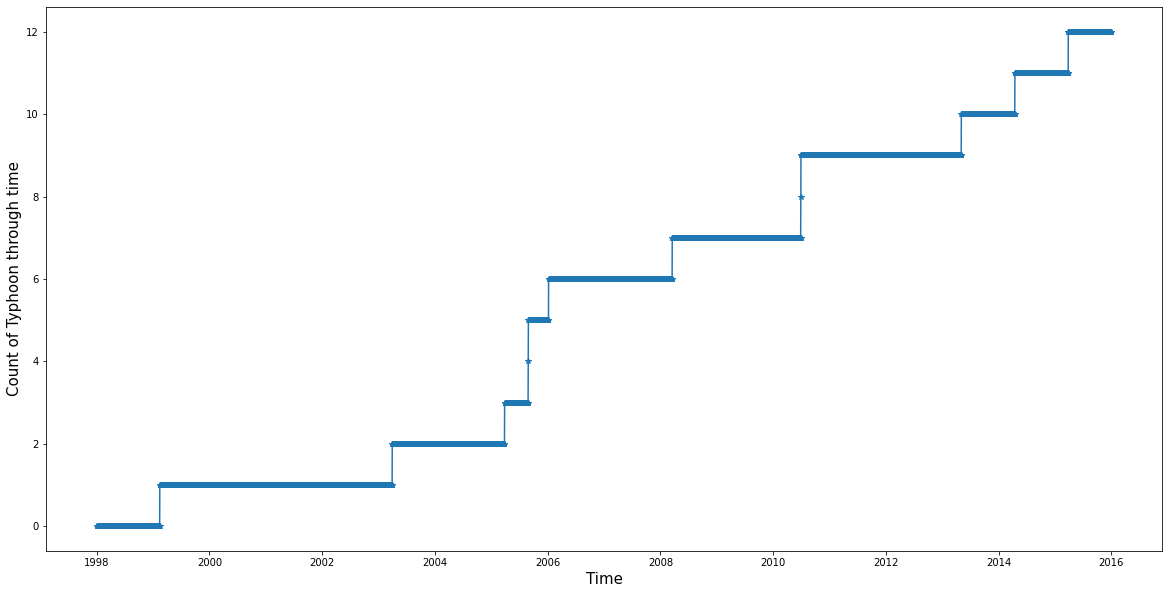

In [123]:
figure(figsize=(20,10))
plot_ts(sst_ts_df['time'], sst_ts_df['typhoon_count'], '-*', 'Count of Typhoon through time')

In [124]:
df_nb_typhoon_per_year = sst_ts_df.groupby(['year']).max()
years = df_nb_typhoon_per_year.index.to_numpy()
nb_typhoon_per_year = zeros(len(df_nb_typhoon_per_year))
count = 0
for year in range(0,18):
  nb_typhoon_per_year[year] = df_nb_typhoon_per_year.iloc[year]['typhoon_count'] - count
  count = df_nb_typhoon_per_year.iloc[year]['typhoon_count']

df_nb_typhoon_per_year['nb_typhoon_per_year'] = nb_typhoon_per_year

In [125]:
df_nb_typhoon_per_year

,time,lon,lat,ssh,sst,diff_sst,typhoon_count,month,nb_typhoon_per_year
year,,,,,,,,,
1998.0,729754.0,270.671675,24.038424,0.413416,30.320099,0.279887,0.0,12.0,0.0
1999.0,730119.0,270.671675,24.038424,0.458868,29.890936,0.299115,1.0,12.0,1.0
2000.0,730485.0,270.671675,24.038424,0.439960,29.745148,0.288176,1.0,12.0,0.0
2001.0,730850.0,270.671675,24.038424,0.439126,29.805813,0.277491,1.0,12.0,0.0
2002.0,731215.0,270.671675,24.038424,0.455429,30.167217,0.286867,1.0,12.0,0.0
2003.0,731580.0,270.671675,24.038424,0.468271,30.063103,0.259635,2.0,12.0,1.0
2004.0,731946.0,270.671675,24.038424,0.454727,30.202241,0.386472,2.0,12.0,0.0
2005.0,732311.0,270.671675,24.038424,0.443971,30.509261,0.305422,5.0,12.0,3.0
2006.0,732676.0,270.671675,24.038424,0.446357,30.352906,0.346511,6.0,12.0,1.0


<BarContainer object of 18 artists>

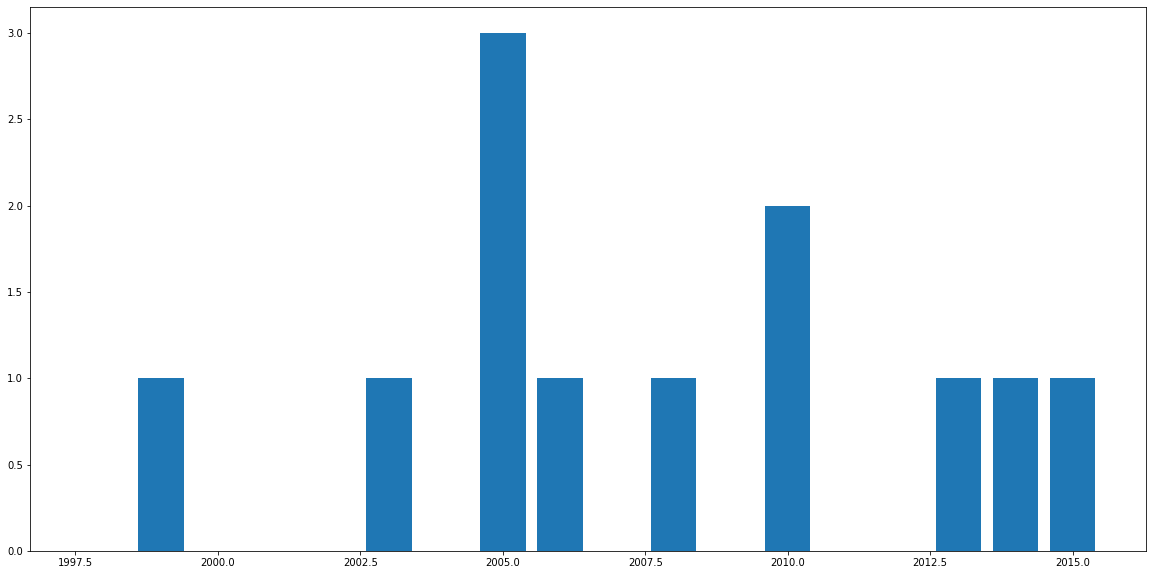

In [126]:
figure(figsize(20,10))
bar(df_nb_typhoon_per_year.index.to_numpy(), df_nb_typhoon_per_year['nb_typhoon_per_year'].to_numpy())

In [127]:
df_nb_typhoon_per_month = sst_ts_df.groupby(['year','month']).mean()
df_nb_typhoon_per_month.reset_index(inplace=True)

In [128]:
df_nb_typhoon_per_month

,year,month,time,lon,lat,ssh,sst,diff_sst,typhoon_count
0,1998.0,1.0,729405.0,270.671675,24.038424,0.343850,23.687088,0.028350,0.0
1,1998.0,2.0,729434.5,270.671675,24.038424,0.341898,23.067997,-0.009958,0.0
2,1998.0,3.0,729464.0,270.671675,24.038424,0.330104,23.074090,-0.025783,0.0
3,1998.0,4.0,729494.5,270.671675,24.038424,0.318175,24.152416,-0.014976,0.0
4,1998.0,5.0,729525.0,270.671675,24.038424,0.344081,26.292635,0.060955,0.0
...,...,...,...,...,...,...,...,...,...
211,2015.0,8.0,735826.0,270.671675,24.038424,0.522114,30.259493,0.004466,12.0
212,2015.0,9.0,735856.5,270.671675,24.038424,0.540202,29.948219,0.004724,12.0
213,2015.0,10.0,735887.0,270.671675,24.038424,0.520242,28.582799,-0.007065,12.0
214,2015.0,11.0,735917.5,270.671675,24.038424,0.496051,27.484626,0.013482,12.0


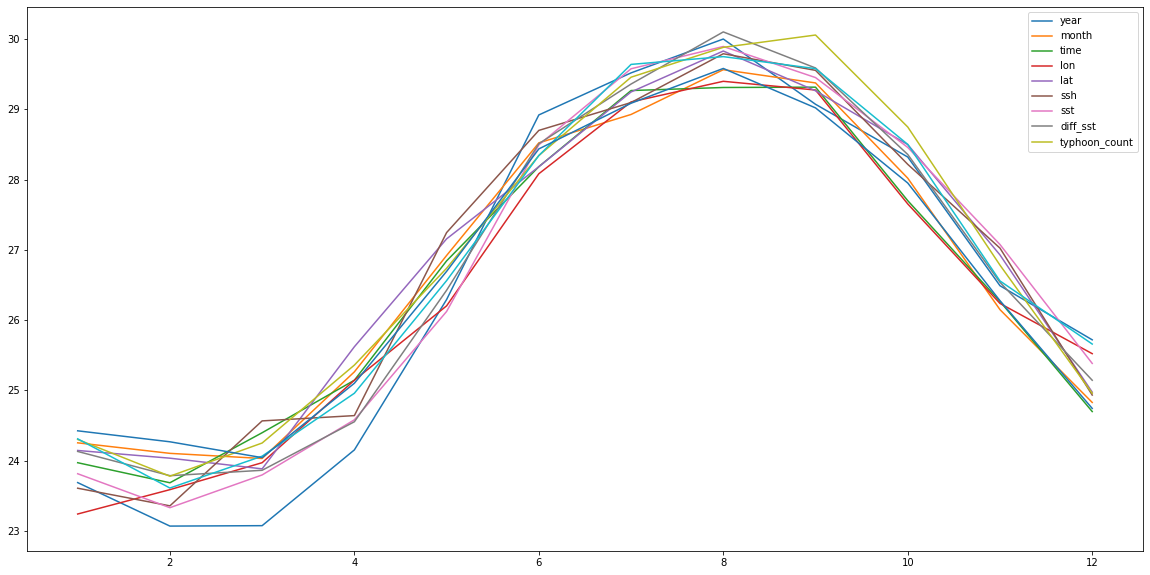

In [129]:
figure(figsize=(20,10))
months = range(1,13)
for i in range(0, 11):
  plot(months, df_nb_typhoon_per_month.iloc[i*12:12 + i*12]['sst'])
  legend(df_nb_typhoon_per_month.iloc[i*12:12 + i*12])

In [130]:
df_ibtracs = pd.read_csv('ibtracs-japan-1998-2015.csv')

FileNotFoundError: ignored

In [ ]:
df_ibtracs

In [ ]:
df_ibtracs['NSEC_TIME'] = pd.to_datetime(df_ibtracs.NSEC_TIME, format='%Y-%m-%d %H:%M:%S')

df_ibtracs['days'] = df_ibtracs['NSEC_TIME'].dt.round('D')

In [ ]:

matplotlib_date = 735963.0
date = mdates.num2date(matplotlib_date)
date.month